In [1]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
from time import time

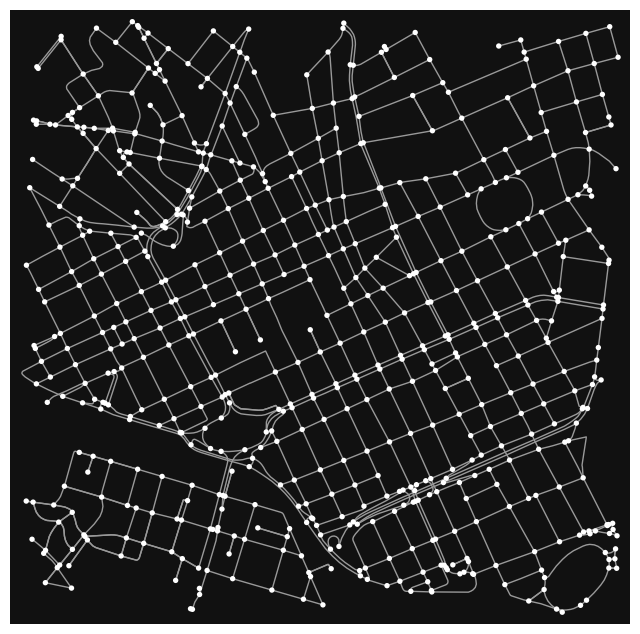

In [4]:
G = ox.graph_from_address('Campinas, São Paulo', network_type='drive')
G = nx.convert_node_labels_to_integers(G)
ox.plot_graph(G)
source = 507
target = 235

In [5]:
class Environment:
    """
    Simulation of graph route that can be deterministic and stochastic.
    The main functionalities is to reset the simulation and returns the state based in the action.
    """

    def __init__(self, G, source, target, reward="weighted", mode="deterministic"):
        self.G = G
        self.max_weight = max([G[u][v][0]["length"] for u, v, m in G.edges if m == 0])
        self.source = source
        self.target = target
        self.target_point = np.array([G.nodes[target]["x"], G.nodes[target]["y"]])
        # get x_range and y_range
        x = [G.nodes[u]["x"] for u in G.nodes]
        y = [G.nodes[u]["y"] for u in G.nodes]
        self.x_range = max(x)- min(x)
        self.y_range = max(y)- min(y)
        # get diagonal dist
        self.diagonal_dist = np.sqrt(self.x_range**2 + self.y_range**2)
        self.reward = reward

        assert mode in [
            "deterministic",
            "stochastic",
        ], "Mode must be deterministic or stochastic"
        if mode == "deterministic":
            self.step = self.step_deterministic
        elif mode == "stochastic":
            self.step = self.step_stochastic

    def get_n_states(self):
        """Get number of states"""
        return len(self.G.nodes)

    def reset(self):
        """Return to the source state that is not the destination"""
        self.state = self.source
        # self.state = np.random.choice(list(self.G.nodes))
        # while self.state == self.target:
        # self.state = np.random.choice(list(self.G.nodes))
        return self.state

    def step_deterministic(self, action):
        """Return new state, reward, and if simulation is done"""

        # if is not the target, and the action is to stay in the same node
        if (action == self.state) & (action != self.target):
            return self.state, -1, False

        # if reached the target
        if self.state == self.target:
            return self.state, 10000, True

        # weight of the edge
        w = self.G[self.state][action][0]["length"] / self.max_weight
        # now, the state is the next node
        self.state = action

        # if the action leaves to a dead end
        neighbors = list(self.G.neighbors(self.state))
        if len(neighbors) == 0:
            return self.state, -1000, True

        if self.reward == "unit":
            return self.state, 0, False
        elif self.reward == "weighted":
            return self.state, -w, False
        elif self.reward == "distance":
            # get distance to the target
            point = np.array([self.G.nodes[self.state]["x"], self.G.nodes[self.state]["y"]])
            distance = np.linalg.norm(point - self.target_point)
            return self.state, -distance/self.diagonal_dist, False
            

    def step_stochastic(self, action):
        """Return new state, reward, and if the destination is reached"""
        if np.random.rand() < 0.05:  # 5% probability of not moving
            return self.state, 0, False

        # if is not the target, and the action is to stay in the same node
        if (action == self.state) & (action != self.target):
            return self.state, -1, False

        # if reached the target
        if self.state == self.target:
            return self.state, 10000, True

        # weight of the edge
        w = self.G[self.state][action][0]["length"] / self.max_weight
        self.state = action

        # if the action leaves to a dead end
        neighbors = list(self.G.neighbors(self.state))
        if len(neighbors) == 0:
            return self.state, -1000, True

        if self.reward == "unit":
            return self.state, 0, False
        elif self.reward == "weighted":
            w_ = w + np.random.normal(scale=0.1)
            return self.state, -w_, False
        elif self.reward == "distance":
            # get distance to the target
            point = np.array([self.G.nodes[self.state]["x"], self.G.nodes[self.state]["y"]])
            distance = np.linalg.norm(point - self.target_point) + np.random.normal(scale=0.1)
            return self.state, -distance/self.diagonal_dist, False


In [6]:
class QLAgent:
    def __init__(
        self,
        env,
        learning_rate = 0.7,
        gamma = 0.99,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
         tol = 1e-6,
        seed = 42
    ):
        self.env = env
        self.n_states = env.get_n_states()
        self.set_Q()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.tol = tol
        self.seed = seed
        if seed is not None:
            self.set_seed(seed)

    def set_Q(self):
        self.Q = np.zeros((self.n_states, self.n_states))
        for state in range(self.n_states):
            for action in range(self.n_states):
                if state == action:
                    self.Q[state, action] = 0
                else:
                    try:
                        self.env.G[state][action][0]["length"]
                        self.Q[state, action] = 0
                    except:
                        self.Q[state, action] = -np.inf

    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)

    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        return np.random.choice(np.where(self.Q[state, :] == np.max(self.Q[state, :]))[0])

    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        # if np.random.uniform(0, 1) < epsilon:
        #     neighbors = list(self.env.G.neighbors(state))
        #     # print(neighbors);
        #     # if there is no neighbors
        #     if (len(neighbors) == 0):
        #       # print("AQUI")
        #       # if there is no neightbors, maybe we get to the target on the next action.
        #       return state
        #     else:
        #       # print("AQUI II")
        #       return np.random.choice(neighbors)
        # else:
        #     return self.greedy_policy(state)
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.env.G.neighbors(state))
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        self.episode_rewards.append(0)
        state = self.env.reset()
        action = self.epsilon_greedy_policy(state, epsilon)
        for step in range(self.max_steps):
            next_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward
            if done and next_state != self.env.target:
                break
            next_action = self.epsilon_greedy_policy(next_state, epsilon)

            # update Q table based on Bellman equation
            self.Q[state, action] += self.learning_rate * (
                reward
                + self.gamma * self.Q[next_state, next_action]
                - self.Q[state, action]
            )
            state = next_state
            action = next_action

            if done and state == self.env.target:
                break


    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes

    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []

        for episode in range(self.n_episodes):
            self.generate_episode(self.epsilon)
            self.update_epsilon()

        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}


    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        k = 0
        while state != target and k < 1000:
            new_state = self.policy[state]
            if new_state == state:
                cost = np.inf
                route.append(new_state)
                break
            cost += G[state][new_state][0]["length"]
            state = new_state
            route.append(state)
            k += 1
        return route, cost

In [7]:
def experiment_handler(seeds, env, fixed_agent_params, testing_agent_param):
    testing_agent_param_name = testing_agent_param[0]
    testing_agent_param_values = testing_agent_param[1]
    results = []
    env.reset()
    for value in tqdm(testing_agent_param_values):
        fixed_agent_params[testing_agent_param_name] = value
        for i, seed in enumerate(seeds):
            start = time()
            agent = QLAgent(
                env = env,
                seed = seed,
                **fixed_agent_params,
            )
            agent.train()
            end = time()
            route, cost = agent.route_to_target(G, env.source, env.target)
            results.append(
                {"seed" : seed,
                 testing_agent_param_name : value,
                 "cost" : cost,
                 "time" : end - start,
                 "rewards" : agent.episode_rewards,
                }
            )
            env.reset()

    return results

In [8]:
def plot_all_paths_policy(G, policy, source, target):
    """Plot the policy for all states, i.e., for each state, plot an arrow indicating the action to take.

    :param G: network
    :type G: networkx.Graph
    :param policy: dict with nodes in keys and the action in values
    :type policy: dict
    :param source: source node
    :type source: int
    :param target: target node
    :type target: int
    """

    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha=0.25,
    )

    for i in G.nodes:
        dest = policy[i]

        # verify if there is a edge between i and dest, if not, continue
        if (i, dest) not in G.edges:
            continue

        plt.arrow(
            G.nodes[i]["x"],
            G.nodes[i]["y"],
            (G.nodes[dest]["x"] - G.nodes[i]["x"]) * 0.7,
            (G.nodes[dest]["y"] - G.nodes[i]["y"]) * 0.7,
            alpha=0.8,
            width=0.0001,
        )

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]],
        [G.nodes[source]["y"], G.nodes[target]["y"]],
        color=["green", "red"],
        alpha=1,
        s=100,
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color="red", label="Target")
    green_patch = mpatches.Patch(color="green", label="Source")
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_few_steps_policy(G, policy, source, target, steps=5):
    """Plot the policy for a sequence of steps, i.e., from an initial position, plot an arrow indicating the action to take, and repeat this process for the next state.

    :param G: network
    :type G: networkx.Graph
    :param policy: dict with nodes in keys and the action in values
    :type policy: dict
    :param source: source node
    :type source: int
    :param target: target node
    :type target: int
    :param steps: number of steps to plot, defaults to 5
    :type steps: int, optional
    """

    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha=0.25,
    )

    # plot the edges
    for u, v, m in G.edges:
        if m == 0:
            plt.plot(
                [G.nodes[u]["x"], G.nodes[v]["x"]],
                [G.nodes[u]["y"], G.nodes[v]["y"]],
                color="black",
                alpha=0.25,
            )

    state = source
    for i in range(steps):
        dest = policy[state]

        # verify if there is a edge between i and dest, if not, continue
        if (state, dest) not in G.edges:
            continue

        plt.arrow(
            G.nodes[state]["x"],
            G.nodes[state]["y"],
            (G.nodes[dest]["x"] - G.nodes[state]["x"]) * 0.95,
            (G.nodes[dest]["y"] - G.nodes[state]["y"]) * 0.95,
            alpha=0.8,
            width=0.0001,
        )
        state = dest

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]],
        [G.nodes[source]["y"], G.nodes[target]["y"]],
        color=["green", "red"],
        alpha=1,
        s=100,
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color="red", label="Target")
    green_patch = mpatches.Patch(color="green", label="Source")
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])

In [9]:
seeds = [960703545, 1277478588, 1936856304, 186872697, 1859168769, 1598189534] + [646357903, 142231913, 683485230, 386942224, 990655951, 602129677]

# Experiments - Deterministic

In [10]:
env = Environment(G, source, target, "unit", "deterministic")
fixed_agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
}
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("./results/unit_deterministic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("./results/unit_deterministic_lr.json")
env = Environment(G, source, target, "weighted", "deterministic")
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("./results/weighted_deterministic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("./results/weighted_deterministic_lr.json")

100%|█████████████████████████████████████████████| 5/5 [00:41<00:00,  8.34s/it]


# Experiments - Stochastic

In [11]:
env = Environment(G, source, target, "unit", "stochastic")
fixed_agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
}
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("./results/unit_stochastic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("./results/unit_stochastic_lr.json")
env = Environment(G, source, target, "weighted", "stochastic")
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("./results/weighted_stochastic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("./results/weighted_stochastic_lr.json")

100%|█████████████████████████████████████████████| 5/5 [00:49<00:00,  9.81s/it]


In [12]:
def analysis_results(reward_method, env_method):
    results_lr = pd.read_json(f"./results/{reward_method}_{env_method}_lr.json")
    results_gamma = pd.read_json(f"./results/{reward_method}_{env_method}_gamma.json")
    results_lr["rewards"] = results_lr.rewards.apply(np.mean)
    results_gamma["rewards"] = results_gamma.rewards.apply(np.mean)

    results_lr = results_lr.groupby("learning_rate").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_lr.columns = ["_".join(col) for col in results_lr.columns]
    results_lr = results_lr.reset_index()

    results_gamma = results_gamma.groupby("gamma").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_gamma.columns = ["_".join(col) for col in results_gamma.columns]
    results_gamma = results_gamma.reset_index()
    better_names = {
        "unit" : "Unit",
        "weighted" : "Weighted",
        "deterministic" : "Deterministic",
        "stochastic" : "Stochastic",
    }
    plot_results_experiments(results_lr, results_gamma, f"Parameter evaluation\n{better_names[reward_method]} reward and {better_names[env_method]} environment")

def plot_results_experiments(results_lr, results_gamma, title):
    """Plot the results of the experiments varying learning rate and gamma.

    Parameters
    ----------
    results_lr : pd.DataFrame
        Dataframe with columns learning_rate, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    results_gamma : pd.DataFrame
        Dataframe with columns gamma, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    title : str 
        Title of the plot
    """
    better_names = {
        "cost" : "Path cost",
        "time" : "Computing time",
        "rewards" : "Rewards",
        "learning_rate" : "Learning rate (α)",
        "gamma" : "Discount factor (γ)",
    }
    def plot_line_plot_err(df, param, cost, ax):
        ax.plot(df[param], df[f"{cost}_mean"], color = "black")
        ax.fill_between(
            df[param],
            df[f"{cost}_mean"] - df[f"{cost}_std"],
            df[f"{cost}_mean"] + df[f"{cost}_std"],
            color = "black",
            alpha = 0.2
        )
        ax.set_xlabel(better_names[param])
        ax.set_ylabel(better_names[cost])
        ax.set_title(f"{better_names[param]} x {better_names[cost]}")
        ax.grid()
        

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 7), sharey="col")
    axs = axs.flatten()

    plot_line_plot_err(results_lr, "learning_rate", "cost", axs[0])
    plot_line_plot_err(results_lr, "learning_rate", "time", axs[1])
    plot_line_plot_err(results_lr, "learning_rate", "rewards", axs[2])

    plot_line_plot_err(results_gamma, "gamma", "cost", axs[3])
    plot_line_plot_err(results_gamma, "gamma", "time", axs[4])
    plot_line_plot_err(results_gamma, "gamma", "rewards", axs[5])

    plt.suptitle(title, fontsize = 14)
    plt.tight_layout()
    plt.show()

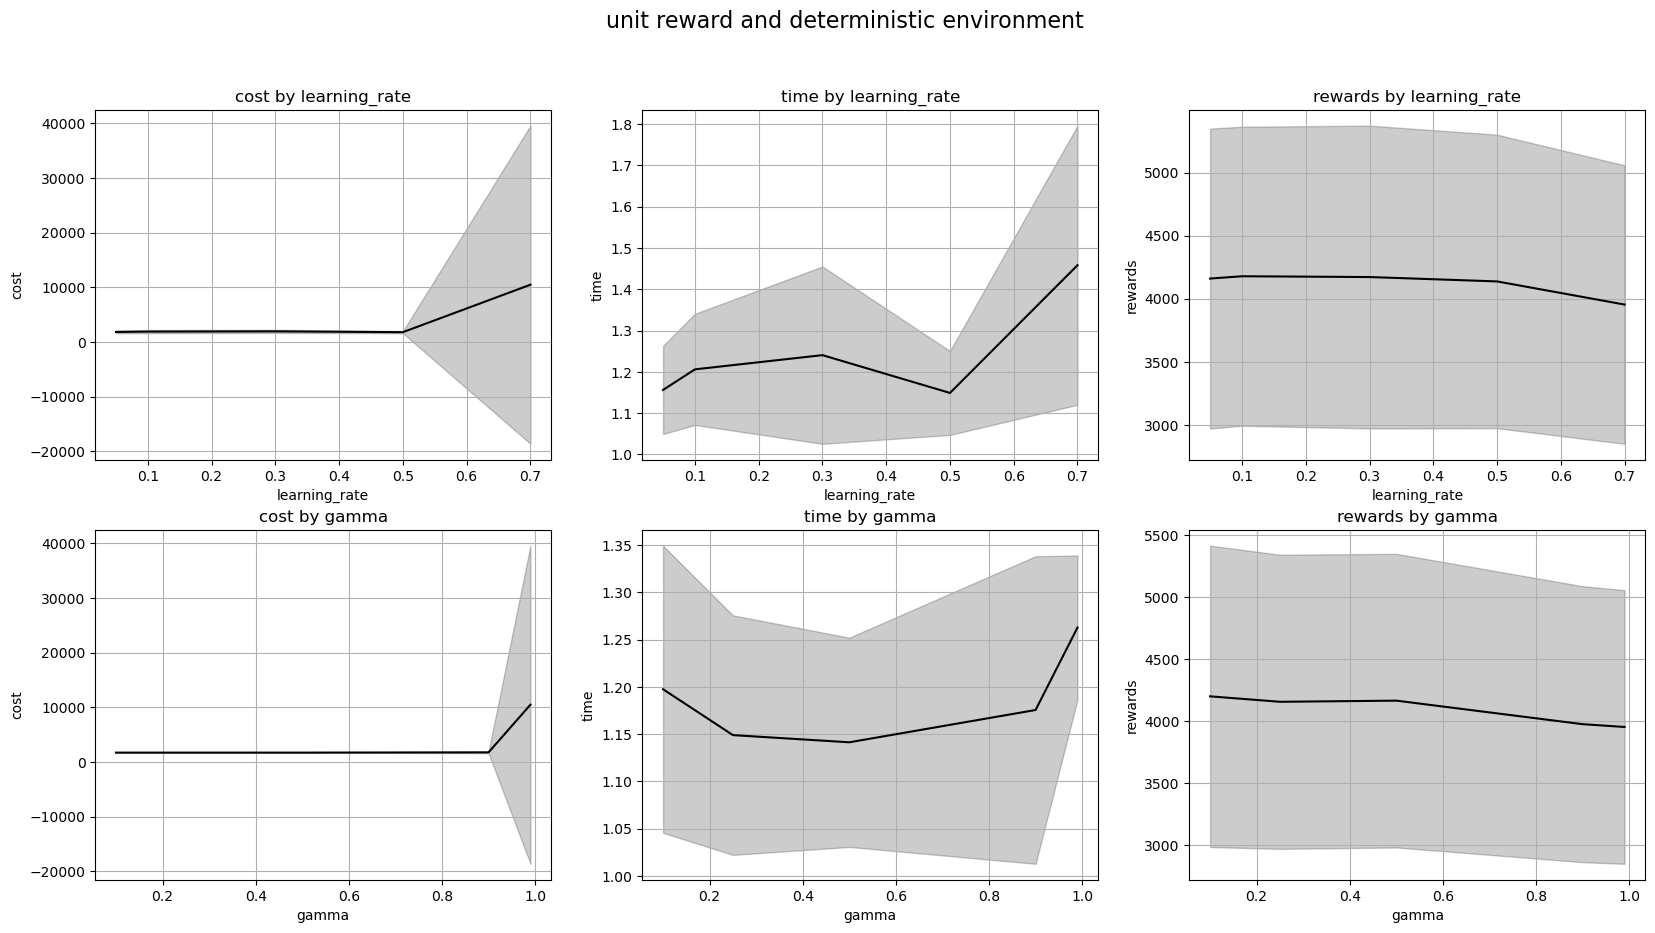

In [13]:
analysis_results("unit", "deterministic")

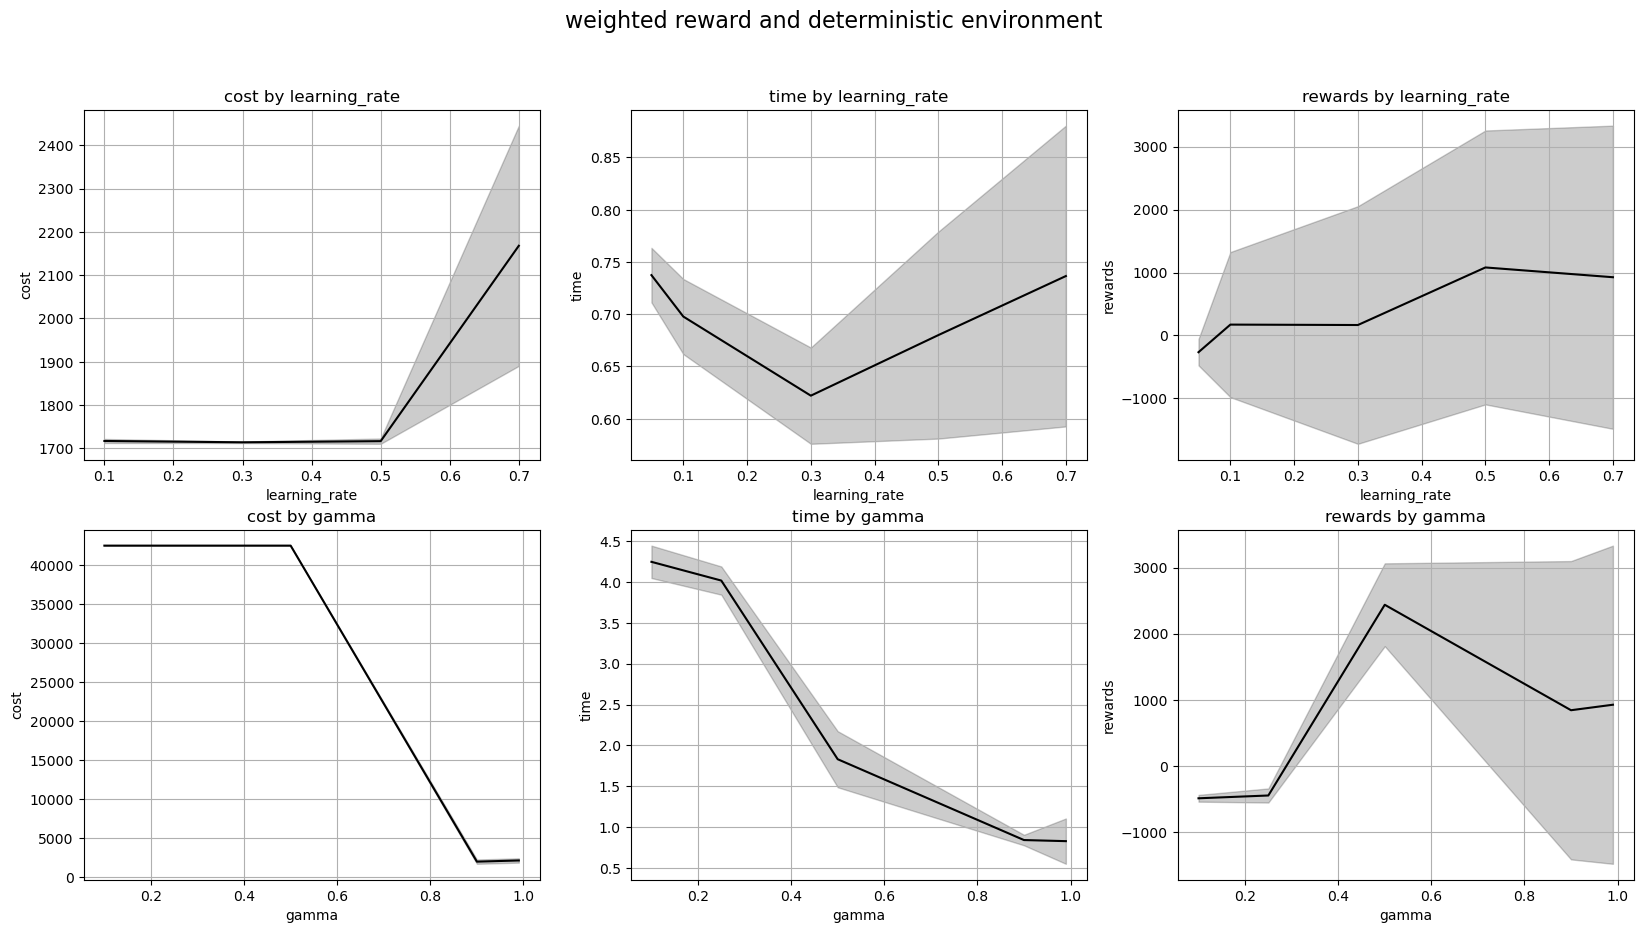

In [14]:
analysis_results("weighted", "deterministic")

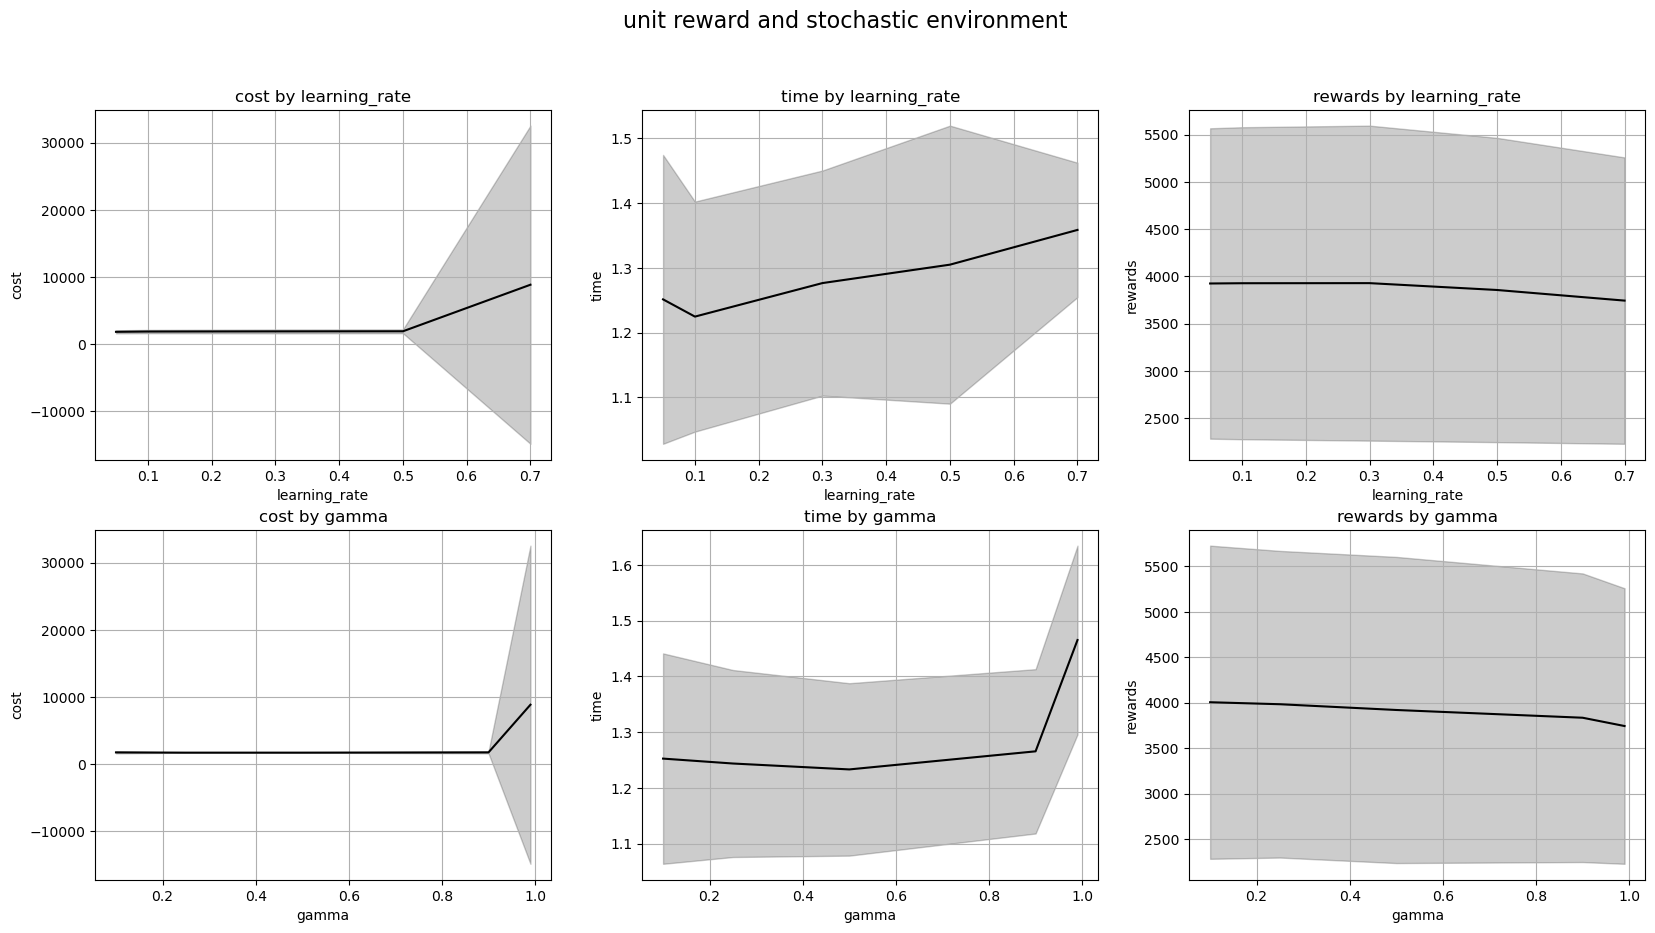

In [15]:
analysis_results("unit", "stochastic")

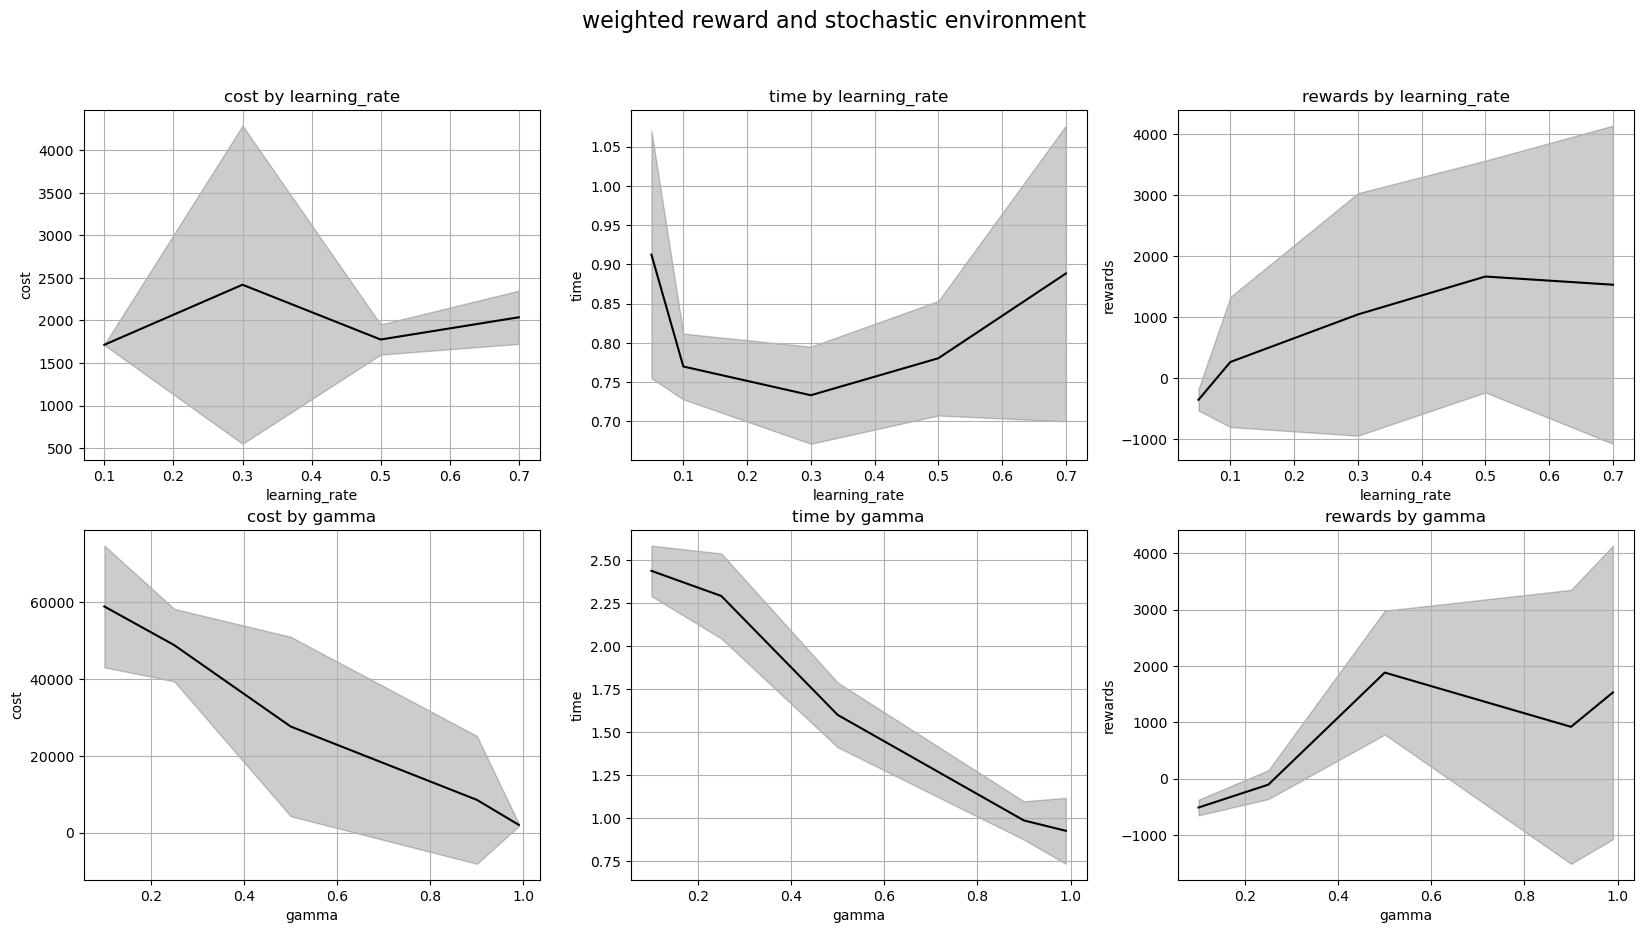

In [16]:
analysis_results("weighted", "stochastic")

# Experiments - Generalization

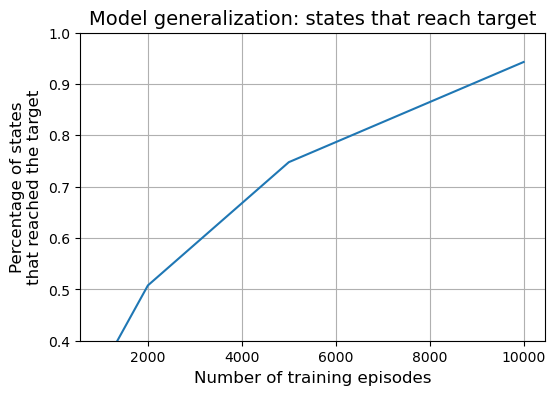

In [17]:
env = Environment(G, source, target, reward = "weighted", mode = "deterministic")
n_episodes_list = [1000, 2000, 5000, 10000]
reach_list = []
for n_episodes in n_episodes_list:
    env.reset()
    agent = QLAgent(env, learning_rate=0.3, gamma = 0.9, n_episodes=n_episodes)
    agent.train()


    n_reached = 0
    n_possible = len(G.nodes)
    for i in range(len(G.nodes)):
        _, cost = agent.route_to_target(G, i, target)
        try:
            opt_cost = nx.shortest_path_length(G, i, target, weight="length")
            if cost < np.inf:
                n_reached += 1
        except:
            n_possible -= 1

    reach_list.append(n_reached / n_possible)

fig = plt.figure(figsize=(6, 4))
plt.plot(n_episodes_list, reach_list)
plt.xlabel("Number of training episodes", fontsize = 12)
plt.ylabel("Percentage of states\nthat reached the target", fontsize = 12)
plt.title("Model generalization: states that reach target", fontsize = 14)
plt.grid()
plt.ylim(0.4, 1)
plt.show()

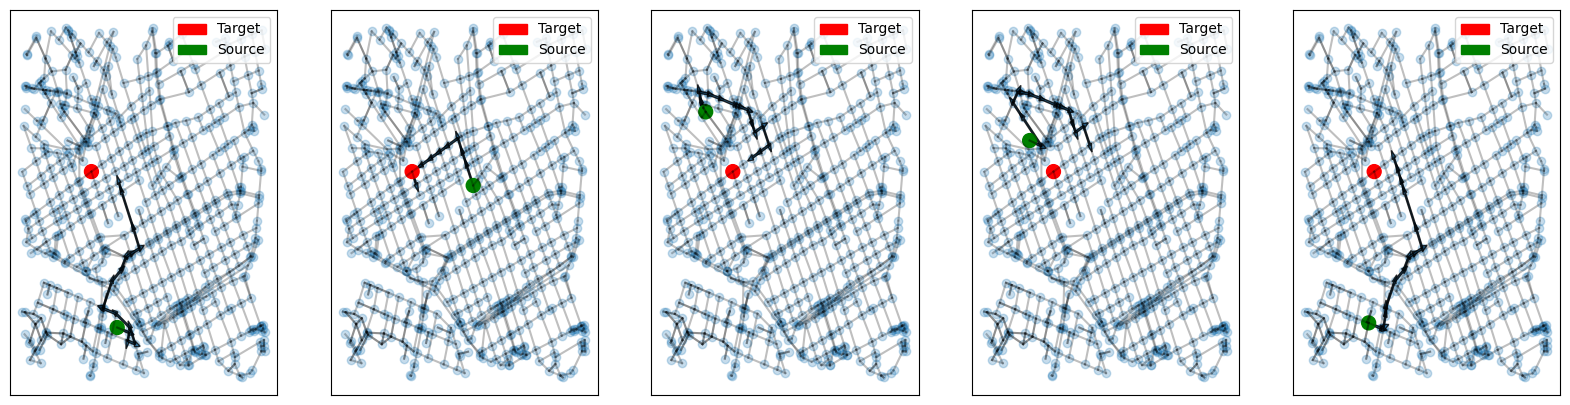

In [18]:
random_states = []

while len(random_states) < 5:
    state = np.random.choice(list(G.nodes))
    if state not in random_states and nx.has_path(G, state, target):
        random_states.append(state)

#fig, axs = plt.subplots(nrows = 1, ncols = 5)

fig = plt.figure(figsize=(20, 5))

for i, state in enumerate(random_states):
    route, cost = agent.route_to_target(G, state, target)

    steps = min(15, len(route))
    plt.subplot(1, 5, i + 1)
    plot_few_steps_policy(G, agent.policy, state, target, steps=steps)

In [19]:
def experiment_handler2(seeds, env, agent_params = {}):
    results = []
    env.reset()
    for i, seed in tqdm(enumerate(seeds)):
        np.random.seed(seed)
        source, target = np.random.choice(env.get_n_states(), size = 2)
        while not nx.has_path(G, source, target):
            source, target = np.random.choice(env.get_n_states(), size = 2)

        env.source = source
        env.target = target
        env.reset()

        start = time()
        agent = QLAgent(env = env, seed = seed, **agent_params)
        agent.train()
        end = time()
        route, cost = agent.route_to_target(G, env.source, env.target)
        optim_cost = nx.shortest_path_length(G, source, target, weight="length")

        results.append({
            "seed" : seed,
            "source" : source,
            "target" : target,
            "cost" : cost / optim_cost,
            "time" : end - start,
            "rewards" : agent.episode_rewards,
        })
    return results

In [20]:
agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
    "learning_rate" : 0.6,
    "gamma" : 0.7,
}
for scheme in ["unit", "weighted"]:
    for simul in ["deterministic", "stochastic"]:
        env = Environment(G, 0, 1, scheme, simul)
        results_general = experiment_handler2(
            seeds,
            env,
            agent_params,
        )
        pd.DataFrame(results_general).to_json(f"./results/{scheme}_{simul}_general.json")

12it [00:08,  1.41it/s]
12it [00:09,  1.31it/s]
12it [00:08,  1.36it/s]
12it [00:09,  1.31it/s]


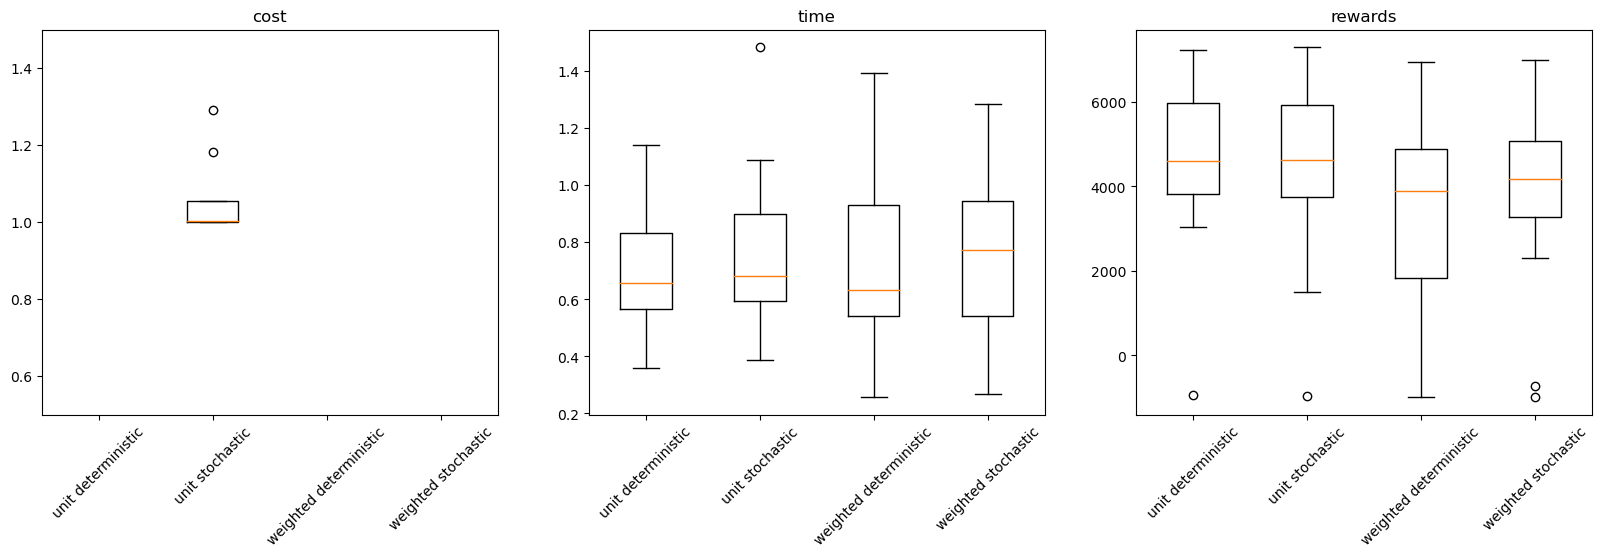

In [21]:
better_names = {
    "time" : "Computing time (s)",
    "cost" : "Path cost / Optimal cost",
    "rewards" : "Mean Rewards of Episodes",
}
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
for i, metric in enumerate(["time", "cost", "rewards"]):
    results_to_plot = []
    for scheme in ["unit", "weighted"]:
        for simul in ["deterministic", "stochastic"]:
            result = pd.read_json(f"results/{scheme}_{simul}_general.json")
            result["rewards"] = result["rewards"].apply(np.mean)
            results_to_plot.append(result[metric])
    axs[i].boxplot(results_to_plot, sym = "")
    if i == 1:
        axs[i].set_ylim(0.95, 2)

    axs[i].set_xticklabels(["Unit\nDeterministic", "Unit\nStochastic", "Weighted\nDeterministic", "Weighted\nStochastic"], rotation = 45)
    axs[i].set_title(better_names[metric])

    axs[i].grid()
plt.tight_layout()
plt.show()

In [22]:
class QLAgent_approx:
    def __init__(
        self, 
        env,
        G,
        learning_rate = 0.5, 
        gamma = 0.95,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
        feature_type = "position",
        seed = None
    ):
        self.env = env
        self.G = G
        self.n_states = env.get_n_states()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.feature_type = feature_type
        self.seed = seed
        if seed is not None:
            self.set_seed(seed)

        self.features = np.zeros((self.n_states, 3))
        for state in range(self.n_states):
            self.features[state, 0] = self.G.nodes[state]["x"]
            self.features[state, 1] = self.G.nodes[state]["y"]
            self.features[state, 2] = len(self.G[state])
        self.features[:, 0] = self.features[:, 0] / np.max(self.features[:, 0])
        self.features[:, 1] = self.features[:, 1] / np.max(self.features[:, 1])
        self.features[:, 2] = self.features[:, 2] / np.max(self.features[:, 2])
        
        self.input_dim = self.get_feature(0, 0).shape[0]
        self.weights = np.zeros(shape = self.input_dim)
        self.weights_history = []

    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    
    def get_feature(self, state, action):
        if self.feature_type == "position":
            features = np.concatenate((self.features[state], self.features[action]))
        elif self.feature_type == "one_hot":
            features = np.zeros(self.n_states * 2 + 6)
            features[state] = 1
            features[self.n_states + action] = 1
            features[-6:-3] = self.features[state]
            features[-3:] = self.features[action]
        elif self.feature_type == "position_large":
            features = np.zeros(self.n_states * 3)
            features[3 * state : 3 * state + 3] = self.features[state]
        return features

    def linear_func(self, state, action, return_feature = False):
        """For each pair of state and action, compute 6 features: 
        (x, y) coordinates of the state/action, and the number of neighbors of each one.
        Then, compute the linear combination of the features with the weights and bias.

        Parameters
        ----------
        state : int
            Index of the state
        action : int
            Index of the action

        Returns
        -------
        float
            Q value of the pair (state, action)
        """
        features = self.get_feature(state, action)
        prediction = np.dot(self.weights, features)
        if return_feature:
            return prediction, features
        return prediction
    
    def update_weights(self, reward, state, action, new_state, new_action):
        """Update the weights and bias based on the Bellman equation"""
        target = reward + self.gamma * self.linear_func(new_state, new_action, False)
        prediction, features = self.linear_func(state, action, True)
        error = target - prediction
        for i in range(len(self.weights)):
            self.weights[i] += self.learning_rate * error * features[i]

    
    def argmax(self, state):
        neighbors = list(self.G.neighbors(state)) + [state]
        return np.max([self.linear_func(state, action) for action in neighbors])
    
    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        neighbors = list(self.G.neighbors(state)) + [state]
        return neighbors[np.argmax([self.linear_func(state, action) for action in neighbors])]
    
    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.env.G.neighbors(state))
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        state = self.env.reset()
        self.episode_rewards.append(0)
        route = [state]
        action = self.epsilon_greedy_policy(state, epsilon)
        for step in range(self.max_steps):
            # Choose action and get reward
            # action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward    
            
            if done and new_state != self.env.target:
                break
            
            new_action = self.epsilon_greedy_policy(new_state, epsilon)
            
            self.update_weights(reward, state, action, new_state, new_action)
            
            state = new_state
            action = new_action
            route.append(state)

            if done and state == self.env.target:
                break
    
    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes
    
    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []
        for episode in range(self.n_episodes):
            self.generate_episode(self.epsilon)
            self.update_epsilon()

            if episode % 100 == 0:
                self.weights_history.append(self.weights.copy())
            
        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}
          

    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        k = 0
        while state != target and k < 1000:
            new_state = self.policy[state]
            if new_state == state:
                cost = np.inf
                route.append(new_state)
                break
            cost += G[state][new_state][0]["length"]
            state = new_state
            route.append(state)
            k += 1
        return route, cost

## Parameter Experiments

In [23]:
def experiment_handler3(seeds, env, fixed_agent_params, testing_agent_param):
    testing_agent_param_name = testing_agent_param[0]
    testing_agent_param_values = testing_agent_param[1]
    results = []
    env.reset()
    for value in tqdm(testing_agent_param_values):
        fixed_agent_params[testing_agent_param_name] = value
        for i, seed in enumerate(seeds):
            start = time()
            agent = QLAgent_approx(
                env = env,
                G = env.G,
                seed = seed,
                **fixed_agent_params,
            )
            agent.train()
            end = time()
            route, cost = agent.route_to_target(G, env.source, env.target)
            results.append(
                {"seed" : seed,
                 testing_agent_param_name : value,
                 "cost" : cost,
                 "time" : end - start,
                 "rewards" : agent.episode_rewards,
                }
            )
            env.reset()

    return results

In [24]:
def analysis_results3(reward_method, env_method):
    results_lr = pd.read_json(f"results/func_{reward_method}_{env_method}_lr.json")
    results_lr["rewards"] = results_lr.rewards.apply(np.mean)

    results_lr = results_lr.groupby("learning_rate").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_lr.columns = ["_".join(col) for col in results_lr.columns]
    results_lr = results_lr.reset_index()

    better_names = {
        "unit" : "Unit",
        "weighted" : "Weighted",
        "deterministic" : "Deterministic",
        "stochastic" : "Stochastic",
        "distance" : "Distance"
    }
    plot_results_experiments2(results_lr, f"Parameter evaluation\n{better_names[reward_method]} reward and {better_names[env_method]} environment")

def plot_results_experiments2(results_lr, title):
    """Plot the results of the experiments varying learning rate and gamma.

    Parameters
    ----------
    results_lr : pd.DataFrame
        Dataframe with columns learning_rate, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    results_gamma : pd.DataFrame
        Dataframe with columns gamma, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    title : str 
        Title of the plot
    """
    better_names = {
        "cost" : "Path cost",
        "time" : "Computing time",
        "rewards" : "Rewards",
        "learning_rate" : "Learning rate (α)",
        "gamma" : "Discount factor (γ)",
    }
    def plot_line_plot_err(df, param, cost, ax):
        ax.plot(df[param], df[f"{cost}_mean"], color = "black")
        ax.fill_between(
            df[param],
            df[f"{cost}_mean"] - df[f"{cost}_std"],
            df[f"{cost}_mean"] + df[f"{cost}_std"],
            color = "black",
            alpha = 0.2
        )
        ax.set_xlabel(better_names[param])
        ax.set_ylabel(better_names[cost])
        ax.set_title(f"{better_names[param]} x {better_names[cost]}")
        ax.grid()
        

    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), sharey="col")
    axs = axs.flatten()

    plot_line_plot_err(results_lr, "learning_rate", "cost", axs[0])
    plot_line_plot_err(results_lr, "learning_rate", "time", axs[1])
    plot_line_plot_err(results_lr, "learning_rate", "rewards", axs[2])


    plt.suptitle(title, fontsize = 14)
    plt.tight_layout()
    plt.show()

In [25]:
fixed_agent_params = {
    "feature_type" : "one_hot",
    "max_steps": 100, 
    "n_episodes" : 5000
}
env = Environment(G, source, target, "unit", "deterministic")
results_lr = experiment_handler3(
    seeds[:5],
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5]]
)
pd.DataFrame(results_lr).to_json("./results/func_unit_deterministic_lr.json")

env = Environment(G, source, target, "weighted", "deterministic")
results_lr = experiment_handler3(
    seeds[:5],
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5]]
)
pd.DataFrame(results_lr).to_json("./results/func_weighted_deterministic_lr.json")



100%|████████████████████████████████████████████| 4/4 [28:17<00:00, 424.38s/it]


In [26]:
fixed_agent_params = {
    "feature_type" : "one_hot",
    "max_steps": 100, 
    "n_episodes" : 5000
}
env = Environment(G, source, target, "unit", "stochastic")
results_lr = experiment_handler3(
    seeds[:5],
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5]]
)
pd.DataFrame(results_lr).to_json("./results/func_unit_stochastic_lr.json")

env = Environment(G, source, target, "weighted", "stochastic")
results_lr = experiment_handler3(
    seeds[:5],
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5]]
)
pd.DataFrame(results_lr).to_json("./results/func_weighted_stochastic_lr.json")


100%|████████████████████████████████████████████| 4/4 [29:49<00:00, 447.49s/it]


In [27]:
fixed_agent_params = {
    "feature_type" : "one_hot",
    "max_steps": 100, 
    "n_episodes" : 5000
}

env = Environment(G, source, target, "distance", "deterministic")
results_lr = experiment_handler3(
    seeds[:5],
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5]]
)
pd.DataFrame(results_lr).to_json("./results/func_distance_deterministic_lr.json")

100%|████████████████████████████████████████████| 4/4 [28:49<00:00, 432.42s/it]


In [28]:
env = Environment(G, source, target, "distance", "stochastic")
results_lr = experiment_handler3(
    seeds[:5],
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5]]
)
pd.DataFrame(results_lr).to_json("./results/func_distance_stochastic_lr.json")

100%|████████████████████████████████████████████| 4/4 [33:05<00:00, 496.31s/it]


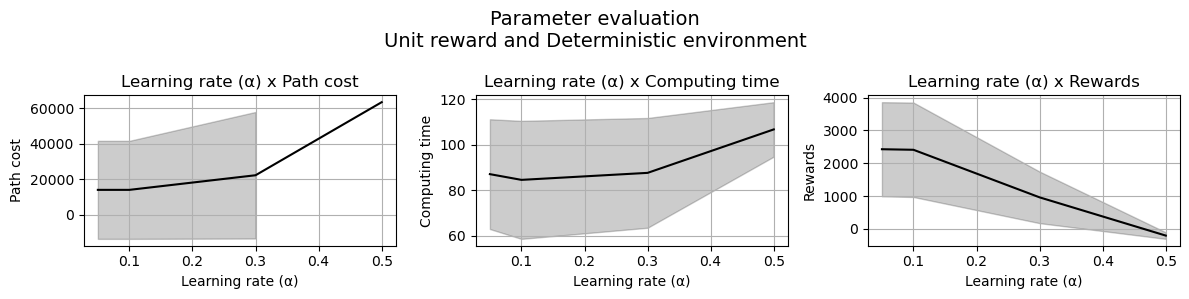

In [29]:
analysis_results3("unit", "deterministic")

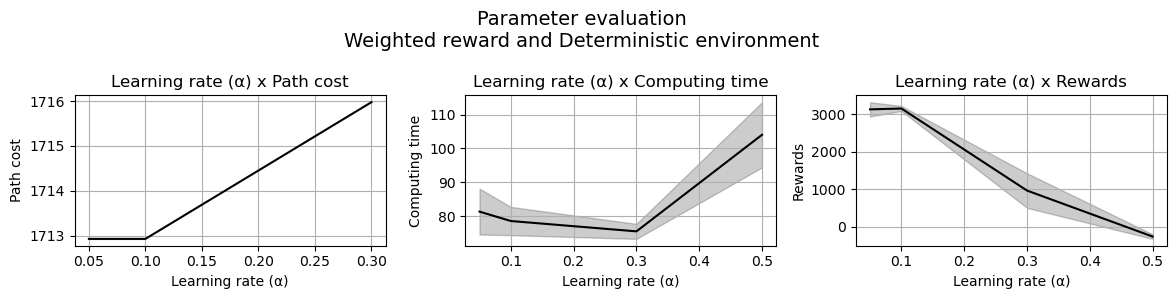

In [30]:
analysis_results3("weighted", "deterministic")

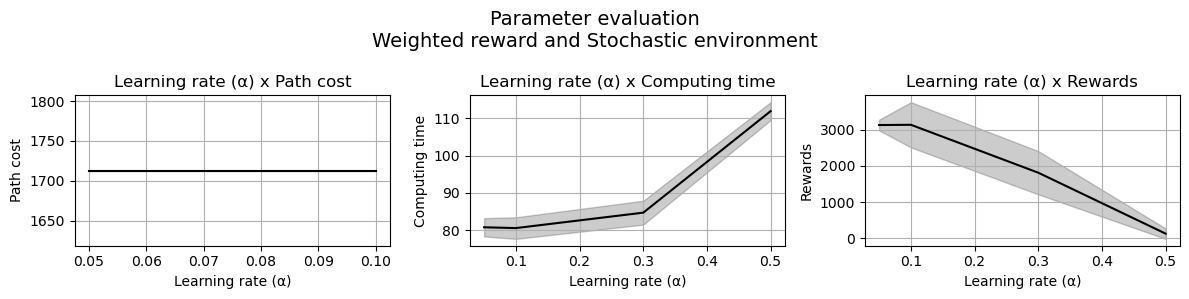

In [31]:
analysis_results3("weighted", "stochastic")

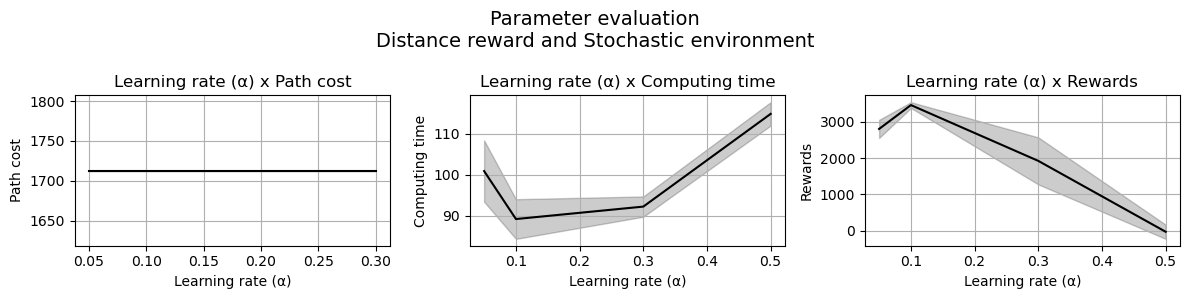

In [32]:
analysis_results3("distance", "stochastic")

In [33]:
env = Environment(G, source, target, reward = "weighted", mode = "deterministic")
agent = QLAgent_approx(env, G, learning_rate=0.1, feature_type = "one_hot", max_steps = 100, n_episodes = 5000)
agent.train()
agent.route_to_target(G, source, target)

([507,
  506,
  400,
  406,
  0,
  386,
  1,
  514,
  393,
  379,
  123,
  140,
  189,
  159,
  174,
  157,
  172,
  181,
  167,
  187,
  235],
 1712.931)

In [34]:
agent.route_to_target(G, source, target)

([507,
  506,
  400,
  406,
  0,
  386,
  1,
  514,
  393,
  379,
  123,
  140,
  189,
  159,
  174,
  157,
  172,
  181,
  167,
  187,
  235],
 1712.931)

In [35]:
agent.episode_rewards

[-1015.3510767053028,
 -1002.500280996396,
 -1007.571117023011,
 -1012.9854361390136,
 -14.409821255603147,
 -15.265807246062698,
 -1011.1668830882367,
 -1011.3453953993313,
 -14.187011253282291,
 -1007.0109176210634,
 -15.219691230035346,
 -1006.0759304049609,
 -13.993869867020608,
 -1011.35199353996,
 -15.128575511307947,
 -1004.0901854576214,
 -16.212573294025802,
 -1014.0540510473589,
 -14.30484176929909,
 -15.595461093028028,
 -16.356121213981158,
 -1009.3739342756143,
 -13.475781563183908,
 -13.918294303924926,
 -1009.8359959260317,
 -14.76296371598074,
 -1002.8024624107381,
 -1005.0713730845732,
 -13.471122585397005,
 -15.5420717777961,
 -17.619020674813328,
 -13.040430873927559,
 -15.823706889110959,
 -1008.4160549640459,
 -13.679010048738018,
 -14.34821687167575,
 -16.03678271594045,
 -14.087837747118591,
 -16.5633968148627,
 -1009.8343847521573,
 -14.495994123051483,
 -13.241307812850636,
 -15.694080278656363,
 -15.126989272267288,
 -14.537811757349544,
 -15.20611133595086,
 

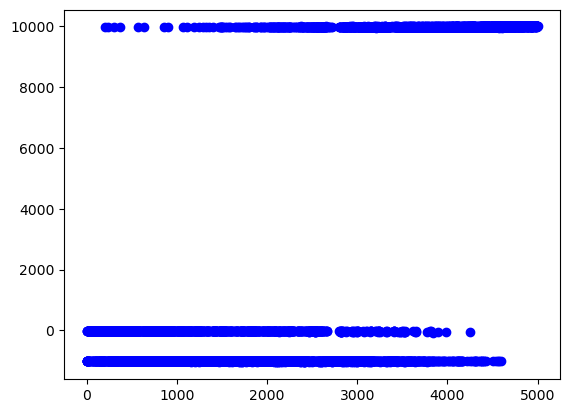

In [36]:
plt.plot(agent.episode_rewards, color="blue", ls='', marker='o')

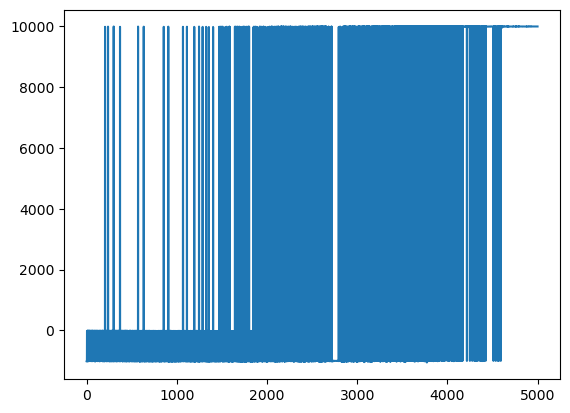

In [37]:
plt.plot(agent.episode_rewards)

In [38]:
len(agent.weights_history)

50

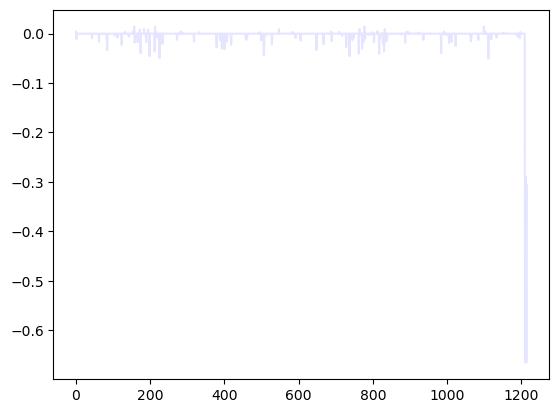

In [39]:
for i in range(0, 10, 50):
    plt.plot(agent.weights_history[0], alpha = min(i * 0.15 + 0.1, 1), c = "b")
plt.show()

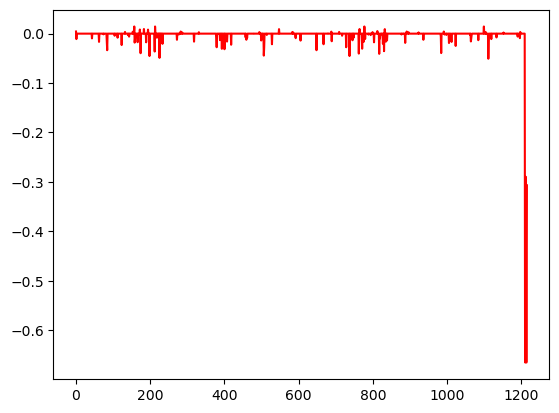

In [40]:
plt.plot(agent.weights_history[0], c = "r")

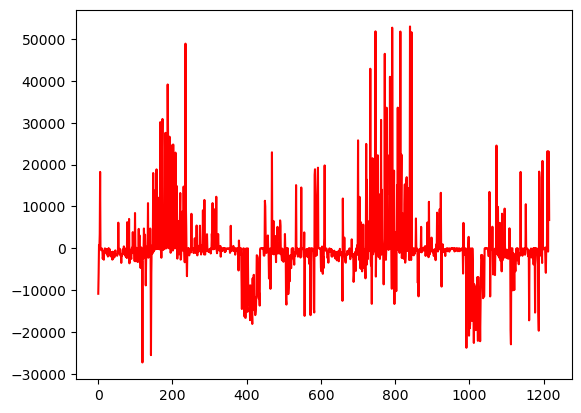

In [41]:
plt.plot(agent.weights_history[int(-1)], c = "r")

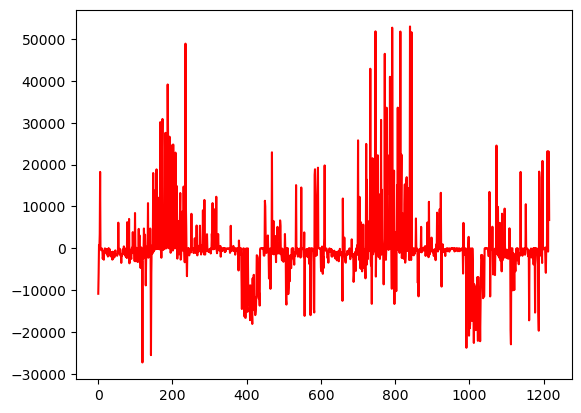

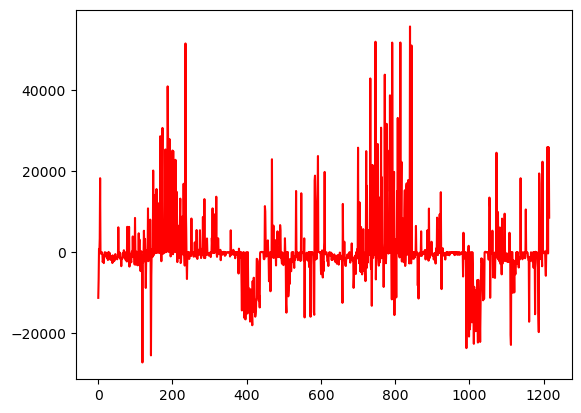

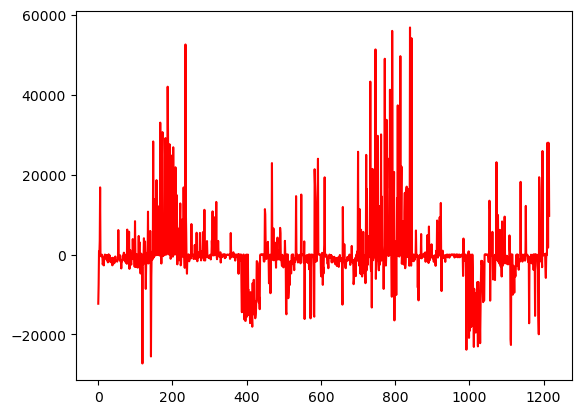

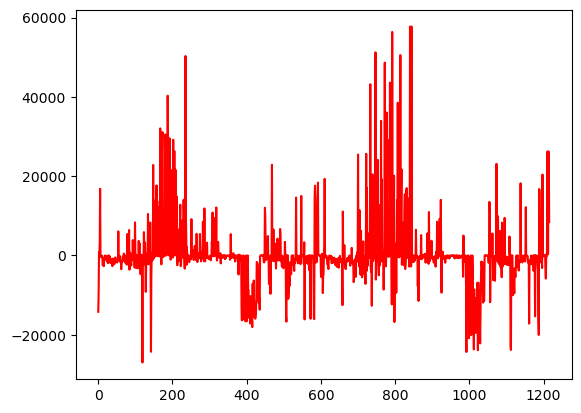

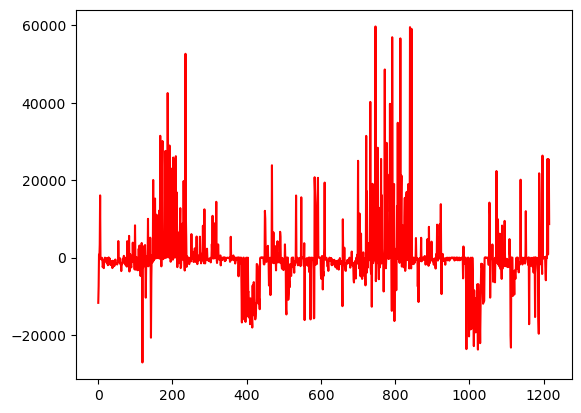

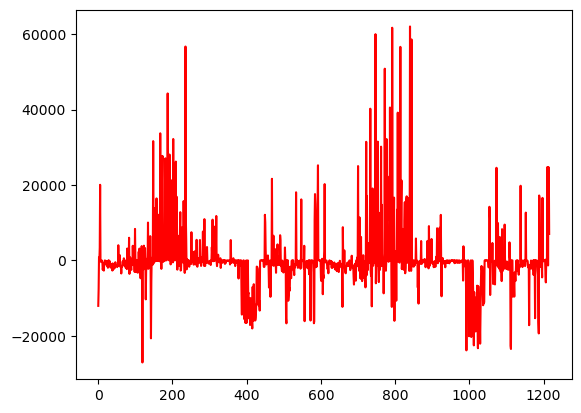

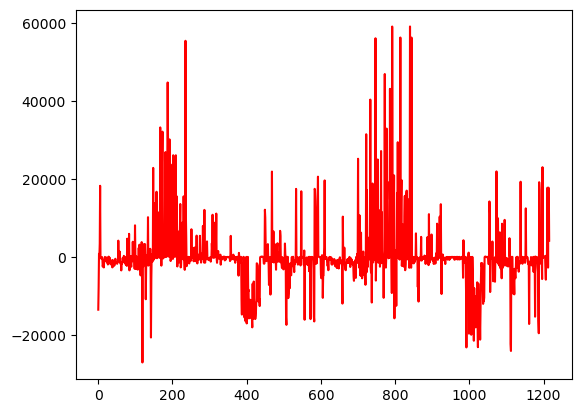

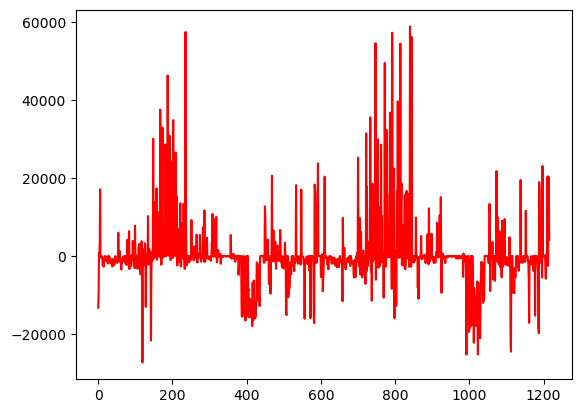

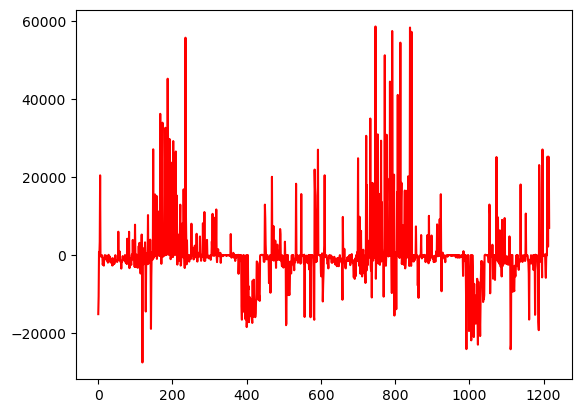

In [42]:
for i in range(1, 10):
    plt.plot(agent.weights_history[int(-i)], c = "r")
    plt.show()

In [43]:
class QLAgent:
    def __init__(
        self,
        env,
        learning_rate = 0.7,
        gamma = 0.99,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
         tol = 1e-6,
        seed = 42
    ):
        self.env = env
        self.n_states = env.get_n_states()
        self.set_Q()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.tol = tol
        self.seed = seed
        if seed is not None:
            self.set_seed(seed)

    def set_Q(self):
        self.Q = np.zeros((self.n_states, self.n_states))
        for state in range(self.n_states):
            for action in range(self.n_states):
                if state == action:
                    self.Q[state, action] = 0
                else:
                    try:
                        self.env.G[state][action][0]["length"]
                        self.Q[state, action] = 0
                    except:
                        self.Q[state, action] = -np.inf

    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)

    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        return np.random.choice(np.where(self.Q[state, :] == np.max(self.Q[state, :]))[0])

    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        # if np.random.uniform(0, 1) < epsilon:
        #     neighbors = list(self.env.G.neighbors(state))
        #     # print(neighbors);
        #     # if there is no neighbors
        #     if (len(neighbors) == 0):
        #       # print("AQUI")
        #       # if there is no neightbors, maybe we get to the target on the next action.
        #       return state
        #     else:
        #       # print("AQUI II")
        #       return np.random.choice(neighbors)
        # else:
        #     return self.greedy_policy(state)
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.env.G.neighbors(state))
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        self.episode_rewards.append(0)
        state = self.env.reset()
        action = self.epsilon_greedy_policy(state, epsilon)
        for step in range(self.max_steps):
            next_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward
            if done and next_state != self.env.target:
                break
            next_action = self.epsilon_greedy_policy(next_state, epsilon)

            # update Q table based on Bellman equation
            self.Q[state, action] += self.learning_rate * (
                reward
                + self.gamma * self.Q[next_state, next_action]
                - self.Q[state, action]
            )
            state = next_state
            action = next_action

            if done and state == self.env.target:
                break


    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes

    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []

        for episode in range(self.n_episodes):
            self.generate_episode(self.epsilon)
            self.update_epsilon()

        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}


    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        k = 0
        while state != target and k < 1000:
            new_state = self.policy[state]
            if new_state == state:
                cost = np.inf
                route.append(new_state)
                break
            cost += G[state][new_state][0]["length"]
            state = new_state
            route.append(state)
            k += 1
        return route, cost